###  <font color='red'>  Important: </font> Before proceeding, run the following cell to check for code updates.

In [1]:
from qarpo.catalog import DemoCatalog
import os
status = DemoCatalog(os.getcwd(), "Demo").ShowRepositoryControls()

Accordion(children=(VBox(children=(Button(description='Update this Demo', layout=Layout(width='50%'), style=Bu…

# Object Detection Demo: Car Detection

This is a sample reference implementation to showcase object detection (car in this case) with single-shot detection (SSD) and Async API.
Async API improves the overall frame-rate of the application by not waiting for the inference to complete but continuing to do things on the host while inference accelerator is busy. 
Specifically, this code demonstrates two parallel inference requests by processing the current frame while the next input frame is being captured. This essentially hides the latency of frame capture.

## Overview of how it works
At start-up the sample application reads the equivalent of command line arguments and loads a network and processes video input with the Inference Engine (IE) library. 
A job is submitted to a hardware accelerator (Intel® Core CPU, Intel® HD Graphics GPU, Intel® Core CPU, Intel® Movidius™ Neural Compute Stick, Intel® Neural Compute Stick 2, Intel® HDDL-R, and Intel® HDDL-F.
After the inference is completed, the output videos are appropriately stored in the /results directory, which can then be viewed within the Jupyter Notebook instance.

## Demonstration objectives
* Video as input is supported using **OpenCV**
* Inference performed on edge hardware (rather than on the development node hosting this Jupyter notebook)
* **OpenCV** provides the bounding boxes, labels and other information
* Visualization of the resulting bounding boxes
* Demonstrate the Async API in action


## Set Up

Run the below cell to import Python dependencies needed for displaying the results in this notebook
(tip: select the cell and use **Ctrl+enter** to run the cell)

In [2]:
from IPython.display import HTML
import matplotlib.pyplot as plt
import os
import time
import sys                                     
from qarpo.demoutils import *
from openvino.inference_engine import IECore, IENetwork
import cv2
# For labeling the image
from out_process import placeBoxes

We will start with running inference on a single image to see how the Intel® Distribution of OpenVINO™ toolkit works, then we will run inference on a video stream.

We will go over detecting cars with OpenVINO in several steps:

1. Create an intermediate representation (IR) of the model using the Model Optimizer.
2. Generate ExecutableNetwork from the IR for inference.
3. Run inference on a single image.
4. Discuss how to extend this to processing a video.
5. Create a job file to target different hardware types.
6. Submit jobs to the queue.
7. View the results and hardware performance comparison.

## 1. Create an Intermediate Representation (IR) of the Model

Model Optimizer creates the Intermediate Representation of the model which is the device-agnostic, generic optimization of the model. Caffe\*, TensorFlow\*, MXNet\*, ONNX\*, and Kaldi\* models are supported by Model Optimizer.

We will use the **MobileNet-SSD** model. Download the model, specifying the name and output directory.

In [3]:
!/opt/intel/openvino/deployment_tools/tools/model_downloader/downloader.py --name mobilenet-ssd -o raw_models

################|| Downloading models ||################

========== Downloading raw_models/public/mobilenet-ssd/mobilenet-ssd.prototxt
... 100%, 28 KB, 44581 KB/s, 0 seconds passed

========== Downloading raw_models/public/mobilenet-ssd/mobilenet-ssd.caffemodel
... 100%, 22605 KB, 16536 KB/s, 1 seconds passed

################|| Post-processing ||################



Let's convert this model to the intermediate representation using Model Optimizer.

In [4]:
!/opt/intel/openvino/deployment_tools/model_optimizer/mo.py \
--input_model raw_models/public/mobilenet-ssd/mobilenet-ssd.caffemodel \
--data_type FP16 \
--output_dir models/mobilenet-ssd/FP16 \
--scale 256 \
--mean_values [127,127,127] 

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/u19887/Reference-samples/iot-devcloud/python/developer_samples/object-detection-python/raw_models/public/mobilenet-ssd/mobilenet-ssd.caffemodel
	- Path for generated IR: 	/home/u19887/Reference-samples/iot-devcloud/python/developer_samples/object-detection-python/models/mobilenet-ssd/FP16
	- IR output name: 	mobilenet-ssd
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Mean values: 	[127,127,127]
	- Scale values: 	Not specified
	- Scale factor: 	256.0
	- Precision of IR: 	FP16
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	False
Caffe specific parameters:
	- Path to Python Caffe* parser generated from caffe.pr

We generated a FP16 version of the IR model in order to get the best performance. If additional accuracy is required, create and use FP32 version. (Note: older versions of OpenVNO required FP32 models for devices without FP16 support, but newer versions will automatically convert FP16 to FP32 if it is not supported)  

## 2. Preparing ExecutableNetwork

To run inference on a device, we need a **`ExecutableNetwork`** object.
This object can be thought of as a plan for executing inference on a target device.

So it needs to know:
1. what network to execute, and
2. what device to target.

In the next few steps we will walk through how to create **`ExecutableNetwork`**

### 2.1 Creating IECore

First we need the **`IECore`** object, which is responsible for generating **`ExecutableNetwork`**.
Creating **`IECore`** object is simple, as constructor for **`IECore`** does not require any arguments.
```python
ie = IECore()
```

We will be using this object (and the variable name) in the following code snippets.

### 2.2 Read the IR of the Model

Next we need to import the optimized IR models.
This is done by creating  **`IENetwork`** with the `xml` and the `bin` files of the IR model. 

Once **`IENetwork`** is created, it is good practice to check to make sure that the network is supported by the device you intend to use. 
To do this, use the `query_network` method of **`IECore`** object.
This method takes **`IENetwork`** object and a string specifying the targetted device, and returns the list of layers that are supported by this device.
Cross-reference this list with all the layers in the network to see if there is a mismatch.
If there is a mismatch, we may have to write a OpenVINO extension or use a different model. 

Finally, the **`IENetwork`** object provides some important information like the name of the network input and output. These will be used in later functions.

In [9]:
def createNetwork(model_xml, model_bin, ie, device):
    # Importing network weights from IR models.
    net = IENetwork(model=model_xml, weights=model_bin)
    
    # Some layers in IR models may be unsupported. 
    supported_layers = ie.query_network(net, device)
    not_supported_layers = [l for l in net.layers.keys() if l not in supported_layers]
    if len(not_supported_layers) != 0:
        raise Exception("Following layers are not supported by the specified device {}:\n {}".
                format(device, ', '.join(not_supported_layers)))
    
    # Getting the input and outputs shapes of the network
    in_blob = next(iter(net.inputs))
    out_blob = next(iter(net.outputs))
    return net,in_blob,out_blob

### 2.3 Creating ExecutableNetwork

Once we have the network, we can load the **`IENetwork`** into **`IECore`** to generate the **`ExecutableNetwork`** object.
This is also where we can configure the **`ExecutableNetwork`** object, and set parameters like what device to target or how many concurrent inferences to run. 


In [10]:
def loadNetwork(ie, net, device):
    # Loading IR model to IECore.
    exec_net = ie.load_network(network=net, num_requests=2, device_name=device)
    return exec_net

And with the **`ExecutaleNetwork`**, you are ready to run inference.

## 3. Running inference on a single image 

Our eventual goal is to run inference on a video, but let's start with a siingle image first.
We will use the functions we created earlier to run a car detection workload on a image of a road with moderate traffic.

But before we can run inference, the input image needs to be prepared so that it can be used with **~ExecutableNetwork`**.

### 3.1 Preprocess Image

Finally, we need to prepare the input image for inference.
The necessary preprocessing may be different from case to case, but some common ones are:
- Reshaping the inputto fit in the network input
- Normalizing input image
- Scaling the RGB value to a range

For our case, we need change the shape and the ordering of the image loaded with OpenCV to be compatible with our network.

In [11]:
def preprocessImage(img_path, net, input_blob):
    # Reading the frame from a jpeg file
    frame = cv2.imread(img_path)
    
    # Reshaping data
    n, c, h, w = net.inputs[input_blob].shape
    in_frame = cv2.resize(frame, (w, h))
    in_frame = in_frame.transpose((2, 0, 1))  # Change data layout from HWC to CHW
    return in_frame.reshape((n, c, h, w)),frame

### 3.2 Run Inference on a Single Frame

Now we are ready to run the inferenceworkload. We will be running in **async_mode** by using `start_async` method. With the async_mode, the inference is started in parallel on either a separate thread or device.
In other words, `start_async` is non-blocking and the main process is free to do any additional processing needed. 
In the next section, we will see an implementation of pipelining to mask the latency of loading and modifying images.

During asynchronous runs, the different images are tracked by an integer `request_id`. Because we only have one image to process, we will just use 0.

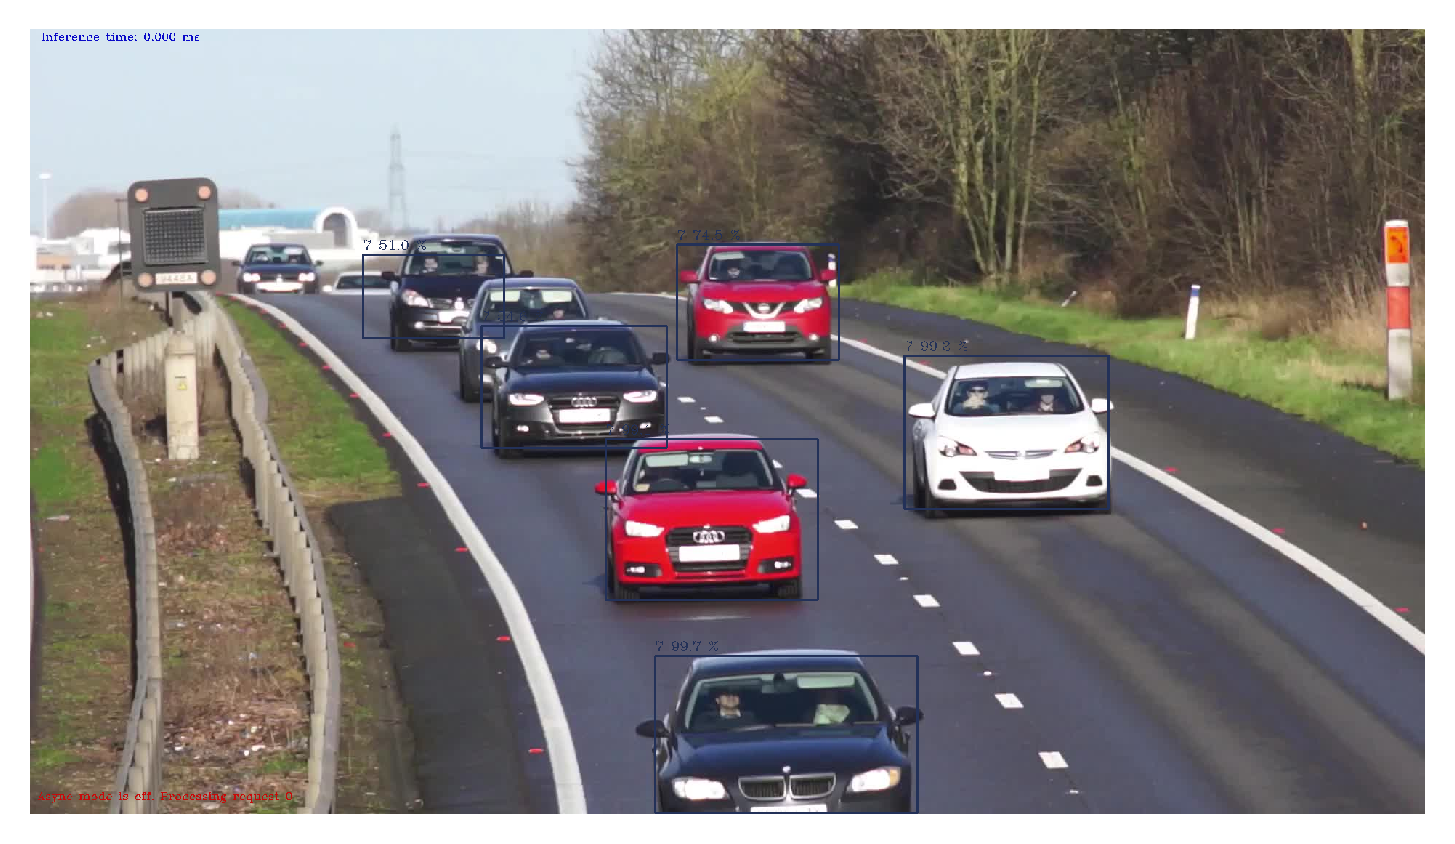

In [12]:
# For labeling the image
from out_process import placeBoxes
import matplotlib.pyplot as plt

# Request id to keep track of
def runInference():
    # Create IECore object
    ie = IECore()
    
    # Create IENetwork object from the mobilenet model
    model_xml = "models/mobilenet-ssd/FP16/mobilenet-ssd.xml"
    model_bin = "models/mobilenet-ssd/FP16/mobilenet-ssd.bin"
    net,input_blob,out_blob = createNetwork(model_xml, model_bin, ie, device='CPU')
    
    # Generate ExecutableNetwork
    exec_net = loadNetwork(ie, net, device="CPU")
    
    # Preprocess image
    in_frame,original_frame = preprocessImage('cars_1900_first_frame.jpg', net, input_blob)

    # Starting the inference in async mode, which starts the inference in parallel
    my_request_id=0
    exec_net.start_async(request_id=my_request_id, inputs={input_blob: in_frame})
    # ... You can do additional processing or latency masking while we wait ...

    # Blocking wait for a particular request_id
    if exec_net.requests[my_request_id].wait(-1) == 0:
        # getting the result of the network
        res = exec_net.requests[my_request_id].outputs[out_blob]
        
        # Processing the output result and adding labels on the image. Implementation is not shown in the
        #  this notebook; you can find it in object_detection_demo_ssd_async.py
        prob_threshold = 0.5  # 50% confidence needed for "detection"
        initial_w = original_frame.shape[1]
        initial_h = original_frame.shape[0]
        frame = placeBoxes(res, None, prob_threshold, original_frame, initial_w, initial_h, False, my_request_id, 0)
        fig = plt.figure(dpi=300)
        ax = fig.add_subplot(111)
        ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), interpolation='none')
        plt.axis("off")
        plt.show()
    else:
        print("There was an error with the request")

runInference()

## 4. Processing a Video

Now that we can run inference on a single image, the next step is to run inference on a video.
Video inferencing is a relatively straight forward extension of single image inferencing.
The video is parsed frame by frame, and each frame is processed in the same way a single image was. 

So for this step, we have provided the inference code in [`object_detection_demo_ssd_async.py`]{object_detection_demo_ssd_async.py} 
Here are descriptions of the major components of the code.

The following lines determine the source of the video. We will use a pre-recorded input video file in this example, we could also use a camera by setting the input argument to 'cam'.

```python
if args.input == 'cam':
        input_stream = 0
        out_file_name = 'cam'
    else:
        input_stream = args.input
```

We capture frames from the video sample using **OpenCV VideoCapture** API.

```python
cap = cv2.VideoCapture(input_stream)
```

Finally, we have a latency masking scheme, where we post-process a frames while other frames are being processed on the inference engine. User can control the number of inference requests running in parallel.

```python
current_inference = 0
required_inference_requests_were_executed = False
previous_inference = 1 - args.number_infer_requests
step = 0
steps_count = args.number_infer_requests - 1

while not required_inference_requests_were_executed or step < steps_count or cap.isOpened():
    # ... load the next frame from cap ...

    # start the next frame
    exec_net.start_async(request_id=current_inference, inputs={input_blob: in_frame})

    # see if the current frame is ready
    if previous_inference >= 0:
        status = infer_requests[previous_inference].wait()
    # ... post-processing current frame ...
    
    # manage request ids
    current_inference += 1
    if current_inference >= args.number_infer_requests:
        current_inference = 0
        required_inference_requests_were_executed = True

    previous_inference += 1
    if previous_inference >= args.number_infer_requests:
        previous_inference = 0

    step += 1
```

The Python code takes in command line arguments for video, model etc.

**Command line arguments options and how they are interpreted in the application source code**

```
SAMPLEPATH="/data/reference-sample-data"
python3 object_detection_demo_ssd_async.py -m ${SAMPLEPATH}/models/mobilenet-ssd/$3/mobilenet-ssd.xml \
                                           -i $INPUT_FILE \
                                           -o $RESULTS_PATH \
                                           -d $DEVICE \
                                           -nireq $NUM_INFER_REQS 
```

##### The description of the arguments used in the argument parser is the command line executable equivalent.
* -m location of the **mobilenet-ssd** pre-trained model which has been pre-processed using the **model optimizer**
   There is automated support built in this argument to support both FP32 and FP16 models targeting different hardware
   (**Note** we are using mobilenet-ssd in this example. However, OpenVINO's Inference Engine is compatible with other neural network architectures such as AlexNet*, GoogleNet*, SqueezeNet* etc.,)    

* -i location of the input video stream (video/cars_1900.mp4)
* -o location where the output file with inference needs to be stored. (results/core or results/xeon or results/gpu)
* -d Type of Hardware Acceleration (CPU or GPU or MYRIAD or HDDL or FPGA)
* -nireq Number of inference requests running in parallel

### 4.1 Input video

To test this inference application, we will run inference on a video wityh moderate traffic. 
Run the following cell to view the input video that we will use.

In [13]:
!ln -sf /data/reference-sample-data/object-detection-python/cars_1900.mp4 
videoHTML('Cars video', ['cars_1900.mp4'])

## 5. Create a Job File

All the code up to this point has been run within the Jupyter Notebook instance running on a development node based on an Intel® Xeon® Scalable Processor, where the Notebook is allocated a single core. To run inference on the entire video, we need more compute power. We will run the workload on several DevCloud's edge compute nodes. We will send work to the edge compute nodes by submitting jobs into a queue. For each job, we will specify the type of the edge compute server that must be allocated for the job.

The job file will be executed directly on the edge compute node.

In [14]:
%%writefile object_detection_job.sh

ME=`basename $0`

# The default path for the job is your home directory, so we change directory to where the files are.
cd $PBS_O_WORKDIR

# Object detection script writes output to a file inside a directory. We make sure that this directory exists.
# The output directory is the first argument of the bash script
while getopts 'd:f:i:r:n:?' OPTION; do
    case "$OPTION" in
    d)
        DEVICE=$OPTARG
        echo "$ME is using device $OPTARG"
      ;;

    f)
        FP_MODEL=$OPTARG
        echo "$ME is using floating point model $OPTARG"
      ;;

    i)
        INPUT_FILE=$OPTARG
        echo "$ME is using input file $OPTARG"
      ;;
    r)
        RESULTS_BASE=$OPTARG
        echo "$ME is using results base $OPTARG"
      ;;
    n)
        NUM_INFER_REQS=$OPTARG
        echo "$ME is running $OPTARG inference requests"
      ;;
    esac  
done

NN_MODEL="mobilenet-ssd.xml"
RESULTS_PATH="${RESULTS_BASE}"
mkdir -p $RESULTS_PATH
echo "$ME is using results path $RESULTS_PATH"

if [ "$DEVICE" = "HETERO:FPGA,CPU" ]; then
    # Environment variables and compilation for edge compute nodes with FPGAs
    # Environment variables and compilation for edge compute nodes with FPGAs - Updated for OpenVINO 2020.1
    source /opt/altera/aocl-pro-rte/aclrte-linux64/init_opencl.sh
    export LD_LIBRARY_PATH=${LD_LIBRARY_PATH}:/opt/intel/openvino_2020.1.023/bitstreams/a10_vision_design_sg1_bitstreams/BSP/a10_1150_sg1/linux64/lib
    aocl program acl0 /opt/intel/openvino/bitstreams/a10_vision_design_sg1_bitstreams/2019R4_PL1_FP16_ResNet.aocx
    export CL_CONTEXT_COMPILER_MODE_INTELFPGA=3
fi
    
# Running the object detection code
SAMPLEPATH=$PBS_O_WORKDIR
python3 object_detection_demo_ssd_async.py  -m ${SAMPLEPATH}/models/mobilenet-ssd/${FP_MODEL}/${NN_MODEL} \
                                            -i $INPUT_FILE \
                                            -o $RESULTS_PATH \
                                            -d $DEVICE \
                                            -nireq $NUM_INFER_REQS 


g++ -std=c++14 ROI_writer.cpp -o ROI_writer_${PBS_JOBID}  -lopencv_core -lopencv_videoio -lopencv_imgproc -lopencv_highgui  -fopenmp -I/opt/intel/openvino/opencv/include/ -L/opt/intel/openvino/opencv/lib/
# Rendering the output video
SKIPFRAME=1
RESOLUTION=0.5
./ROI_writer_${PBS_JOBID} $INPUT_FILE $RESULTS_PATH $SKIPFRAME $RESOLUTION
rm -f ROI_writer_${PBS_JOBID}

Writing object_detection_job.sh


### 5.1 Optional Change of Video Quality

Video rendering is a separate task invoked by `ROI_writer` at the end of the job. To reduce rendering time, you can reduce the output video quality using the SKIP_FRAME and RESOLUTION variables. 

`SKIP_FRAME=1` writes all processed video frames with bounding boxes into the output video. This is the slowest option and it preserves all inference data in the output video stream. `SKIP_FRAME=2` writes every other frame of the processed frames into the output video.

`RESOLUTION=1` produces the output video with the same resolution as the input video; this is the slowest option.
`RESOLUTION<1` reduces the output video resolution. Here we have `RESOLUTION=0.5` which sets the output video resolution in each dimension to 50% of the input video's resolution.


## 6. Job queue submission

With the job script andpython code ready, we can test the video inferencing application on various devices.

The systems in the DevCloud are equipped with various types of edge hardware thatcan help with running computer vision workloads on the Edge.
In the DevCloud these systems are organized by short descriptive properties.
Here, the properties describe the node, and number on the left is the number of available nodes of that architecture.


In [8]:
!pbsnodes | grep compnode | awk '{print $3}' | sort | uniq -c

      1 sb1,agg,compnode,iei,tank-870,intel-core,i5-7500t,kaby-lake,intel-hd-630,ram8gb,net1gbe
      1 sb1,col,compnode,iei,tank-870,intel-core,i5-7500t,kaby-lake,intel-hd-630,ram8gb,net1gbe
      1 sb1,idc001skl,idc002mx8,compnode,iei,tank-870,intel-core,i5-6500te,skylake,intel-hd-530,ram8gb,net1gbe,hddl-r,iei-mustang-v100-mx8
      1 sb1,idc003a10,idc001skl,idc003a10,compnode,iei,tank-870,intel-core,i5-6500te,skylake,intel-hd-530,ram8gb,net1gbe,hddl-f,iei-mustang-f100-a10
      1 sb1,idc004nc2,idc001skl,idc004nc2,compnode,iei,tank-870,intel-core,i5-6500te,skylake,intel-hd-530,ram8gb,net1gbe,ncs,intel-ncs2
      1 sb1,idc007xv5,compnode,iei,tank-870,intel-xeon,e3-1268l-v5,skylake,intel-hd-p530,ram32gb,net1gbe
      1 sb1,idc008u2g,compnode,up-squared,grove,intel-atom,e3950,apollo-lake,intel-hd-505,ram4gb,net1gbe,ncs,intel-ncs2


When submitting jobs, we can request a certain piece of hardware by specifying a list of properties that we want.
In the following cells, you will see arguments like:
```
-l nodes=1:idc001skl:tank-870:i5-6500te
```
This is requesting 1 node with properties `idc001skl`, `tank-870`, and `i5-6500te`

We have prepared the cells below to submit a job to different edge compute nodes.
The output of the cell is the `JobID` of your job, which you can use to track progress of a job.

**Note** You can submit all 5 jobs at once or follow one at a time. 

After submission, they will go into a queue and run as soon as the requested compute resources become available. 
(tip: **shift+enter** will run the cell and automatically move you to the next cell. So you can hit **shift+enter** multiple times to quickly run multiple cells)

**Note** If you want to use your own video, Change the environment variable 'VIDEO' in the following cell from "/data/reference-sample-data/safety-gear-detection/Safety_Full_Hat_and_Vest.mp4" to the full path of your uploaded video.

In [15]:
os.environ["VIDEO"] = "/data/reference-sample-data/object-detection-python/cars_1900.mp4"

### Intel® CPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a 
    href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel 
    Core i5-6500TE</a>. The inference workload will run on the CPU.

In [16]:
#Submit job to the queue
job_id_core = !qsub object_detection_job.sh -l nodes=1:idc001skl:tank-870:i5-6500te -F "-r results/ -d CPU -f FP32 -i $VIDEO -n 2" -N obj_det_core
print(job_id_core[0]) 
#Progress indicators
if job_id_core:
    progressIndicator('results/', 'pre_progress_{}.txt'.format(job_id_core[0]), "Preprocessing", 0, 100)
    progressIndicator('results/', 'i_progress_{}.txt'.format(job_id_core[0]), "Inference", 0, 100)
    progressIndicator('results/', 'post_progress_{}.txt'.format(job_id_core[0]), "Rendering", 0, 100)

818.v-qsvr-sb1.devcloud-edge


### Intel® Xeon® CPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a 
    href="https://ark.intel.com/products/88178/Intel-Xeon-Processor-E3-1268L-v5-8M-Cache-2-40-GHz-">Intel 
    Xeon Processor E3-1268L v5</a>. The inference workload will run on the CPU.

In [17]:
#Submit job to the queue
job_id_xeon = !qsub object_detection_job.sh -l nodes=1:idc007xv5:e3-1268l-v5 -F "-r results/ -d CPU -f FP32 -i $VIDEO -n 2" -N obj_det_xeon 
print(job_id_xeon[0]) 
#Progress indicators
if job_id_xeon:
    progressIndicator('results/', 'pre_progress_{}.txt'.format(job_id_xeon[0]), "Preprocessing", 0, 100)
    progressIndicator('results/', 'i_progress_{}.txt'.format(job_id_xeon[0]), "Inference", 0, 100)
    progressIndicator('results/', 'post_progress_{}.txt'.format(job_id_xeon[0]), "Rendering", 0, 100)

819.v-qsvr-sb1.devcloud-edge


### Intel® Core CPU with Intel® GPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core i5-6500TE</a>. The inference workload will run on the Intel® HD Graphics 530 card integrated with the CPU.

In [18]:
#Submit job to the queue
job_id_gpu = !qsub object_detection_job.sh -l nodes=1:idc001skl:intel-hd-530 -F "-r results/ -d GPU -f FP32 -i $VIDEO -n 4" -N obj_det_gpu 
print(job_id_gpu[0]) 
#Progress indicators
if job_id_gpu:
    progressIndicator('results/', 'pre_progress_{}.txt'.format(job_id_gpu[0]), "Preprocessing", 0, 100)
    progressIndicator('results/', 'i_progress_{}.txt'.format(job_id_gpu[0]), "Inference", 0, 100)
    progressIndicator('results/', 'post_progress_{}.txt'.format(job_id_gpu[0]), "Rendering", 0, 100)

820.v-qsvr-sb1.devcloud-edge


### Intel® Arria® 10 FPGA
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core i5-6500te CPU</a> . The inference workload will run on the <a href="https://www.ieiworld.com/mustang-f100/en/"> IEI Mustang-F100-A10 </a> card installed in this node.

In [19]:
#Submit job to the queue
job_id_fpga = !qsub object_detection_job.sh -l nodes=1:idc003a10:iei-mustang-f100-a10 -F "-r results/ -d HETERO:FPGA,CPU -f FP16 -i $VIDEO -n 4" -N obj_det_fpga

print(job_id_fpga[0]) 
#Progress indicators
if job_id_fpga:
    progressIndicator('results/', 'pre_progress_{}.txt'.format(job_id_fpga[0]), "Preprocessing", 0, 100)
    progressIndicator('results/', 'i_progress_{}.txt'.format(job_id_fpga[0]), "Inference", 0, 100)
    progressIndicator('results/', 'post_progress_{}.txt'.format(job_id_fpga[0]), "Rendering", 0, 100)

821.v-qsvr-sb1.devcloud-edge


### Intel® Neural Compute Stick 2
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core i5-6500te CPU</a>. The inference workload will run on an <a 
    href="https://software.intel.com/en-us/neural-compute-stick">Intel Neural Compute Stick 2</a> installed in this  node.

In [20]:
#Submit job to the queue
job_id_ncs2 = !qsub object_detection_job.sh -l nodes=1:idc004nc2:intel-ncs2 -F "-r results/ -d MYRIAD -f FP16 -i $VIDEO -n 4" -N obj_det_ncs2
print(job_id_ncs2[0]) 
#Progress indicators
if job_id_ncs2:
    progressIndicator('results/', 'pre_progress_{}.txt'.format(job_id_ncs2[0]), "Preprocessing", 0, 100)
    progressIndicator('results/', 'i_progress_{}.txt'.format(job_id_ncs2[0]), "Inference", 0, 100)
    progressIndicator('results/', 'post_progress_{}.txt'.format(job_id_ncs2[0]), "Rendering", 0, 100)

822.v-qsvr-sb1.devcloud-edge


### IEI Mustang-V100-MX8 ( Intel® Movidius™ Myriad™ X Vision Processing Unit (VPU))
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core i5-6500te CPU</a>. The inference workload will run on an <a 
    href="https://www.ieiworld.com/mustang-v100/en/">IEI Mustang-V100-MX8 </a>accelerator installed in this node.

In [21]:
#Submit job to the queue
job_id_hddlr = !qsub object_detection_job.sh -l nodes=1:idc002mx8:iei-mustang-v100-mx8 -F "-r results/ -d HDDL -f FP16 -i $VIDEO -n 128" -N obj_det_hddlr
print(job_id_hddlr[0]) 
#Progress indicators
if job_id_hddlr:
    progressIndicator('results/', 'pre_progress_{}.txt'.format(job_id_hddlr[0]), "Preprocessing", 0, 100)
    progressIndicator('results/', 'i_progress_{}.txt'.format(job_id_hddlr[0]), "Inference", 0, 100)
    progressIndicator('results/', 'post_progress_{}.txt'.format(job_id_hddlr[0]), "Rendering", 0, 100)

823.v-qsvr-sb1.devcloud-edge


### UP Squared Grove IoT Development Kit
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/up-squared-grove-dev-kit">UP Squared Grove IoT Development Kit</a> edge node with an <a 
    href="https://ark.intel.com/products/96488/Intel-Atom-x7-E3950-Processor-2M-Cache-up-to-2-00-GHz-">Intel Atom® x7-E3950 Processor</a>. The inference  workload will run on the integrated Intel® HD Graphics 505 card.

In [22]:
#Submit job to the queue
job_id_up2 = !qsub object_detection_job.sh -l nodes=1:up-squared -F "-r results/ -d GPU -f FP32 -i $VIDEO -n 2" -N obj_det_up2
print(job_id_up2[0]) 
#Progress indicators
if job_id_up2:
    progressIndicator('results/', 'pre_progress_{}.txt'.format(job_id_up2[0]), "Preprocessing", 0, 100)
    progressIndicator('results/', 'i_progress_{}.txt'.format(job_id_up2[0]), "Inference", 0, 100)
    progressIndicator('results/', 'post_progress_{}.txt'.format(job_id_up2[0]), "Rendering", 0, 100)

824.v-qsvr-sb1.devcloud-edge


### 6.1 Check the Progress

Check the progress of the jobs. `Q` status stands for `queued`, `R` for `running`. How long a job is being queued is dependent on number of the users. It should take up to 5 minutes for a job to run. If the job is no longer listed, it's done. 

In [23]:
liveQstat()

Output(layout=Layout(border='1px solid gray', height='300px', width='100%'))

Button(description='Stop', style=ButtonStyle())

You should see the jobs you have submitted (referenced by `Job ID` that gets displayed right after you submit the job in step 2.3).
There should also be an extra job in the queue "jupyterhub": this job runs your current Jupyter Notebook session.

The 'S' column shows the current status. 
- If it is in Q state, it is in the queue waiting for available resources. 
- If it is in R state, it is running. 
- If the job is no longer listed, it means it is completed.

**Note**: Time spent in the queue depends on the number of users accessing the edge nodes. Once these jobs begin to run, they should take from 1 to 5 minutes to complete. 

***Wait!***

Please wait for the inference jobs and video rendering complete before proceeding to the next step.

## 6.2 While you wait...

### Why do we have three progress indicators for every job? 

In a real-life inference application, the video processing pipeline may have these phases:

1. Preprocessing (such as video decoding, frame capture from camera, or fetching a frame from a network, resizing, cropping, contrast normalization, etc.) The performance of this phase will often depend on the CPU, storage, and networking speed.
2. Inference (running a neural network forward propagation procedure). The performance of inference depends mostly on the compute device (CPU or an accelerator).
3. Postprocessing (feeding data into the next pipeline stage, writing to file, sending it to a database, or even encoding a new video for a human viewer). This phase will often use the CPU, storage, or network, and will not use an accelerator.

In our demonstration samples, we separate these three phases into separate workloads. This separation allows you to independently judge the relative impact of each phase and draw conclusions for your applications. 

### What does it mean for my application?

Your application may have more or less pre/post-processing work depending on how you get your data (from storage, sensor or network), what is the resolution of your raw data, is it encoded or not, whether you need to produce an output video, etc. Therefore, you need to understand how your processing pipeline relates to this demo before drawing conclusions on performance.

In this demo, we provide three performance numbers for each architecture. However, they are not hard limits on the solution's performance. You need to relate these numbers and code to what you are doing in your own project.

### The total time is not necessarily equal to the sum of the parts

It is important to realize that in a real-life application, you may want to fuse preprocessing, inference, and postprocessing, as opposed to separating them as we did here. Fused preprocessing has several advantages:
* If inference is run asynchronously on the accelerator, the rest of the system is free for preprocessing future frames or postprocessing past frames. This allows you to mask the pre/post processing time behind inference time. 
* With fused preprocessing, inference and postprocessing, your pipeline has better data locality, allowing you to reuse data in the caches, in the application's memory, or in the hard drive cache. 



## 7. View Results

Once the jobs are completed, the queue system outputs the `stdout` and `stderr` streams of each job into files with names
`obj_det_{type}.o{JobID}` and `obj_det_{type}.e{JobID}`. Here, obj_det_{type} corresponds to the `-N` option of qsub. For example, `core` for Core CPU target.

You can find the output video files inside the `results` directory. We wrote a short utility script that will display these videos within the notebook. See `demoutils.py` if you are interested in understanding further how the results are displayed in notebook. 

`obj_det_{type}.e{JobID}`

(here, obj_det_{type} corresponds to the `-N` option of qsub).

However, for this case, we may be more interested in the output video files. They are stored in mp4 format inside the `results/` directory.
We wrote a short utility script that will display these videos with in the notebook.
Run the cells below to display them.
See `demoutils.py` if you are interested in understanding further how the results are displayed in notebook.

In [ ]:
videoHTML('IEI Tank (Intel Core CPU)', 
          ['results/output_{}.mp4'.format(job_id_core[0])], 
          'results/stats_{}.txt'.format(job_id_core[0]))

In [ ]:
videoHTML('IEI Tank Xeon (Intel Xeon CPU)',
          ['results/output_{}.mp4'.format(job_id_xeon[0])],
          'results/stats_{}.txt'.format(job_id_xeon[0]))

In [ ]:
videoHTML('IEI Intel GPU (Intel Core + Onboard GPU)', 
          ['results/output_{}.mp4'.format(job_id_gpu[0])],
          'results/stats_{}.txt'.format(job_id_gpu[0]))

In [ ]:
videoHTML('IEI Tank + IEI Mustang-F100-A10 (Intel® Arria® 10 FPGA)',
          ['results/output_{}.mp4'.format(job_id_fpga[0])],
          'results/stats_{}.txt'.format(job_id_fpga[0]))

In [ ]:
videoHTML('IEI Tank + Intel CPU + Intel NCS2',
          ['results/output_{}.mp4'.format(job_id_ncs2[0])],
          'results/stats_{}.txt'.format(job_id_ncs2[0]))

In [ ]:
videoHTML('IEI Tank + IEI Mustang-V100-MX8 ( Intel® Movidius™ Myriad™ X Vision Processing Unit (VPU))',
          ['results/output_{}.mp4'.format(job_id_hddlr[0])],
          'results/stats_{}.txt'.format(job_id_hddlr[0]))

In [ ]:
videoHTML('UP Squared Grove IoT Development Kit (UP2)',
          ['results/output_{}.mp4'.format(job_id_up2[0])],
          'results/stats_{}.txt'.format(job_id_up2[0]))

### 7.1 Performance Comparison

The running time of each inference task is recorded in `stats_*job_id*_*architectute*.txt` in `results` folder, where the *architecture* corresponds to the architecture of the target edge compute node. Run the cell below to plot the results of all jobs side-by-side. Lower values for processing time mean better performance. Keep in mind that some architectures are optimized for the highest performance, others for low power or other metrics.

In [ ]:
arch_list = [('core', 'Intel Core\ni5-6500TE\nCPU'),
             ('xeon', 'Intel Xeon\nE3-1268L v5\nCPU'),
             ('gpu', ' Intel Core\ni5-6500TE\nGPU'),
             ('fpga', ' IEI Mustang\nF100-A10\nFPGA'),
             ('hddlr', ' IEI Mustang\nV100-MX8\nVPU'),
             ('ncs2', 'Intel\nNCS2'),
             ('up2', 'Intel Atom\nx7-E3950\nUP2/GPU')]

stats_list = []
for arch, a_name in arch_list:
    if 'job_id_'+arch in vars():
        stats_list.append(('results/stats_'+vars()['job_id_'+arch][0]+'.txt', a_name))
    else:
        stats_list.append(('placeholder'+arch, a_name))

summaryPlot(stats_list, 'Architecture', 'Time, seconds', 'Inference Engine Processing Time', 'time' )
summaryPlot(stats_list, 'Architecture', 'Frames per second', 'Inference Engine FPS', 'fps' )